# SOLUTION Advanced ML Week 3, Lecture 1: Text Vectorization - Sequences

In [1]:
from IPython.display import display, Markdown
with open("../Data-AmazonReviews/Amazon Product Reviews.md") as f:
    display(Markdown(f.read()))

# Amazon Product Reviews

- URL: https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews 

## Description

This is a large crawl of product reviews from Amazon. This dataset contains 82.83 million unique reviews, from around 20 million users.

## Basic statistics

| Ratings:  | 82.83 million        |
| --------- | -------------------- |
| Users:    | 20.98 million        |
| Items:    | 9.35 million         |
| Timespan: | May 1996 - July 2014 |

## Metadata

- reviews and ratings
- item-to-item relationships (e.g. "people who bought X also bought Y")
- timestamps
- helpfulness votes
- product image (and CNN features)
- price
- category
- salesRank

## Example

```
{  "reviewerID": "A2SUAM1J3GNN3B",  "asin": "0000013714",  "reviewerName": "J. McDonald",  "helpful": [2, 3],  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",  "overall": 5.0,  "summary": "Heavenly Highway Hymns",  "unixReviewTime": 1252800000,  "reviewTime": "09 13, 2009" }
```

## Download link

See the [Amazon Dataset Page](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/) for download information.

The 2014 version of this dataset is [also available](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon/links.html).

## Citation

Please cite the following if you use the data:

**Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering**

R. He, J. McAuley

*WWW*, 2016
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/www16a.pdf)

**Image-based recommendations on styles and substitutes**

J. McAuley, C. Targett, J. Shi, A. van den Hengel

*SIGIR*, 2015
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir15.pdf)

In [2]:
import tensorflow as tf
import numpy as np
# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

# MacOS Sonoma Fix
tf.config.set_visible_devices([], 'GPU')

In [3]:
import pandas as pd 
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)



In [4]:
import joblib
df = joblib.load('../Data-AmazonReviews/processed_data.joblib')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8191 entries, 0 to 8256
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   overall            8191 non-null   float64
 1   text-raw           8191 non-null   object 
 2   length             8191 non-null   int64  
 3   text               8191 non-null   object 
 4   lower_text         8191 non-null   object 
 5   tokens             8191 non-null   object 
 6   no_stops           8191 non-null   object 
 7   no_stops_no_punct  8191 non-null   object 
 8   spacy_lemmas       8191 non-null   object 
 9   bigrams            8191 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 703.9+ KB


,overall,text-raw,length,text,lower_text,tokens,no_stops,no_stops_no_punct,spacy_lemmas,bigrams
0,4.0,Not going to show you the dirty water on here because I have shame and it ...: Used it twice already and I have absolutely seen results. Not going to show you the dirty water on here because I have shame and it is gross. I will say that while you...,672,Not going to show you the dirty water on here because I have shame and it ...: Used it twice already and I have absolutely seen results. Not going to show you the dirty water on here because I have shame and it is gross. I will say that while you...,not going to show you the dirty water on here because i have shame and it ...: used it twice already and i have absolutely seen results. not going to show you the dirty water on here because i have shame and it is gross. i will say that while you...,"[not, going, to, show, you, the, dirty, water, on, here, because, i, have, shame, and, it, ..., :, used, it, twice, already, and, i, have, absolutely, seen, results, ., not, going, to, show, you, the, dirty, water, on, here, because, i, have, sha...","[going, show, dirty, water, shame, ..., :, used, twice, already, absolutely, seen, results, ., going, show, dirty, water, shame, gross, ., say, 're, cleaning, ,, leave, place, second, (, instance, ,, 're, moving, plug, new, outlet, ), ,, leak, li...","[going, show, dirty, water, shame, ..., used, twice, already, absolutely, seen, results, going, show, dirty, water, shame, gross, say, 're, cleaning, leave, place, second, instance, 're, moving, plug, new, outlet, leak, little, water, part, sucks...","[go, dirty, water, shame, twice, absolutely, see, result, go, dirty, water, shame, gross, clean, leave, place, second, instance, move, plug, new, outlet, leak, little, water, suck, upward, big, deal, suck, right, happen, end, cleaning, remove, ta...","[(go, dirty), (dirty, water), (water, shame), (shame, twice), (twice, absolutely), (absolutely, see), (see, result), (result, go), (go, dirty), (dirty, water), (water, shame), (shame, gross), (gross, clean), (clean, leave), (leave, place), (place..."
1,5.0,Makes carpet look brand new!!!: When you get the shampooer you have to put it together but is very easy...the handle is the only thing that you have to attach...\n\n My carpets were very dirty because I have 2 small dogs that go in and hour all d...,1021,Makes carpet look brand new!!!: When you get the shampooer you have to put it together but is very easy...the handle is the only thing that you have to attach...\n\n My carpets were very dirty because I have 2 small dogs that go in and hour all d...,makes carpet look brand new!!!: when you get the shampooer you have to put it together but is very easy...the handle is the only thing that you have to attach...\n\n my carpets were very dirty because i have 2 small dogs that go in and hour all d...,"[makes, carpet, look, brand, new, !, !, !, :, when, you, get, the, shampooer, you, have, to, put, it, together, but, is, very, easy, ..., the, handle, is, the, only, thing, that, you, have, to, attach, ..., my, carpets, were, very, dirty, because...","[makes, carpet, look, brand, new, !, !, !, :, get, shampooer, put, together, easy, ..., handle, thing, attach, ..., carpets, dirty, 2, small, dogs, go, hour, day, ..., 1st, day, got, shampoo, shampooed, entire, house, made, huge, difference, ., w...","[makes, carpet, look, brand, new, get, shampooer, put, together, easy, ..., handle, thing, attach, ..., carpets, dirty, 2, small, dogs, go, hour, day, ..., 1st, day, got, shampoo, shampooed, entire, house, made, huge, difference, week, later, dow...","[make, carpet, look, brand, new, shampooer, easy, handle, thing, attach, carpet, dirty, 2, small, dog, hour, day, 1st, day, get, shampoo, shampoo, entire, house, huge, difference, week, later, downstair, dirt, carpet, shampoo, carpet, look, brian...","[(make, carpet), (carpet, look), (look, brand), (brand, new), (new, shampooer), (shampooer, easy), (easy, handle),

In [5]:
def create_groups(x):
    if x>=5.0:
        return "high"
    elif x <=2.0:
        return "low"
    else: 
        return None
    

To understand what customers do and do not like about Hoover products, we will define 2 groups:
- High Ratings
    - Overall rating = 5.0
- Low Ratings
    - Overall rating = 1.0 or 2.0


We can use a function and .map to define group names based on the numeric overall ratings.

In [6]:
## Use the function to create a new "rating" column with groups
df['rating'] = df['overall'].map(create_groups)
df['rating'].value_counts(dropna=False)

high    5547
None    1832
low      812
Name: rating, dtype: int64

In [7]:
## Check class balance of 'rating'
df['rating'].value_counts(normalize=True)

high    0.872307
low     0.127693
Name: rating, dtype: float64

In [8]:
df['length (characters)'] = df['text'].map(len)
df

,overall,text-raw,length,text,lower_text,tokens,no_stops,no_stops_no_punct,spacy_lemmas,bigrams,rating,length (characters)
0,4.0,Not going to show you the dirty water on here because I have shame and it ...: Used it twice already and I have absolutely seen results. Not going to show you the dirty water on here because I have shame and it is gross. I will say that while you...,672,Not going to show you the dirty water on here because I have shame and it ...: Used it twice already and I have absolutely seen results. Not going to show you the dirty water on here because I have shame and it is gross. I will say that while you...,not going to show you the dirty water on here because i have shame and it ...: used it twice already and i have absolutely seen results. not going to show you the dirty water on here because i have shame and it is gross. i will say that while you...,"[not, going, to, show, you, the, dirty, water, on, here, because, i, have, shame, and, it, ..., :, used, it, twice, already, and, i, have, absolutely, seen, results, ., not, going, to, show, you, the, dirty, water, on, here, because, i, have, sha...","[going, show, dirty, water, shame, ..., :, used, twice, already, absolutely, seen, results, ., going, show, dirty, water, shame, gross, ., say, 're, cleaning, ,, leave, place, second, (, instance, ,, 're, moving, plug, new, outlet, ), ,, leak, li...","[going, show, dirty, water, shame, ..., used, twice, already, absolutely, seen, results, going, show, dirty, water, shame, gross, say, 're, cleaning, leave, place, second, instance, 're, moving, plug, new, outlet, leak, little, water, part, sucks...","[go, dirty, water, shame, twice, absolutely, see, result, go, dirty, water, shame, gross, clean, leave, place, second, instance, move, plug, new, outlet, leak, little, water, suck, upward, big, deal, suck, right, happen, end, cleaning, remove, ta...","[(go, dirty), (dirty, water), (water, shame), (shame, twice), (twice, absolutely), (absolutely, see), (see, result), (result, go), (go, dirty), (dirty, water), (water, shame), (shame, gross), (gross, clean), (clean, leave), (leave, place), (place...",None,672
1,5.0,Makes carpet look brand new!!!: When you get the shampooer you have to put it together but is very easy...the handle is the only thing that you have to attach...\n\n My carpets were very dirty because I have 2 small dogs that go in and hour all d...,1021,Makes carpet look brand new!!!: When you get the shampooer you have to put it together but is very easy...the handle is the only thing that you have to attach...\n\n My carpets were very dirty because I have 2 small dogs that go in and hour all d...,makes carpet look brand new!!!: when you get the shampooer you have to put it together but is very easy...the handle is the only thing that you have to attach...\n\n my carpets were very dirty because i have 2 small dogs that go in and hour all d...,"[makes, carpet, look, brand, new, !, !, !, :, when, you, get, the, shampooer, you, have, to, put, it, together, but, is, very, easy, ..., the, handle, is, the, only, thing, that, you, have, to, attach, ..., my, carpets, were, very, dirty, because...","[makes, carpet, look, brand, new, !, !, !, :, get, shampooer, put, together, easy, ..., handle, thing, attach, ..., carpets, dirty, 2, small, dogs, go, hour, day, ..., 1st, day, got, shampoo, shampooed, entire, house, made, huge, difference, ., w...","[makes, carpet, look, brand, new, get, shampooer, put, together, easy, ..., handle, thing, attach, ..., carpets, dirty, 2, small, dogs, go, hour, day, ..., 1st, day, got, shampoo, shampooed, entire, house, made, huge, difference, week, later, dow...","[make, carpet, look, brand, new, shampooer, easy, handle, thing, attach, carpet, dirty, 2, small, dog, hour, day, 1st, day, get, shampoo, shampoo, entire, house, huge, difference, week, later, downstair, dirt, carpet, shampoo, carpet, look, brian...","[(make, carpet), (carpet, look), (look, brand), (brand, new), (new, shampooer)

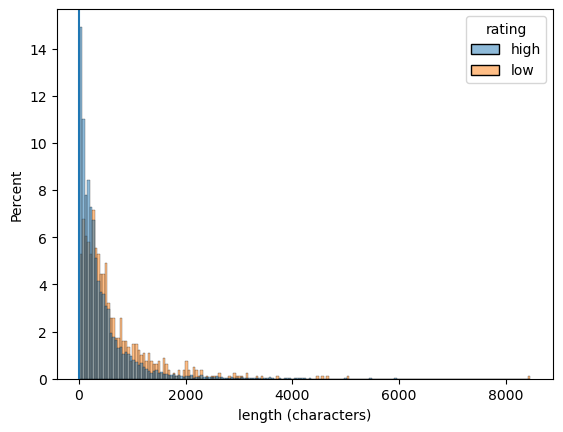

In [9]:
ax = sns.histplot(data=df, hue='rating', x='length (characters)',
                stat='percent',common_norm=False)#, estimator='median',);
ax.axvline()

In [10]:
# Create a df_ml without null ratings
df_ml = df.dropna(subset=['rating'])
df_ml.isna().sum()

overall                0
text-raw               0
length                 0
text                   0
lower_text             0
tokens                 0
no_stops               0
no_stops_no_punct      0
spacy_lemmas           0
bigrams                0
rating                 0
length (characters)    0
dtype: int64

In [11]:
## X - Option A)  lemmas
# def join_tokens(token_list):
#     joined_tokens = ' '.join(token_list)
#     return joined_tokens
# X = df_ml['spacy_lemmas'].apply(join_tokens)

# X - Option B) original raw text
X = df_ml['text']

# y - use our binary target 
y = df_ml['rating']
X.head(10)

1     Makes carpet look brand new!!!: When you get the shampooer you have to put it together but is very easy...the handle is the only thing that you have to attach...\n\n My carpets were very dirty because I have 2 small dogs that go in and hour all d...
4     VERY DISAPPOINTED: WORKED for maybe 1/2 hr and then it appeared the motor got hot and shut off and 10 secs later would start again and would work for 10 or 15 secs and quit again.......sending it back to HOOVER this week......I was VERY DISAPPOIN...
5                                                                 Perfect!: I love this cleaner!  It's easy to operate, light enough to manipulate and easy to clean. The tank holds plenty of shampoo and water solution and the suction for removal is great.
6     Wow - way exceeded expectations: I had the older model from probably 2001 and it was great for the occasional pet stain or the muddy paw prints on white carpet situation, but it was not for routine cleaning.  It finally konked

In [12]:
y.value_counts(normalize=True)

high    0.872307
low     0.127693
Name: rating, dtype: float64

In [13]:
# ## Split data into train, test, val
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.5, random_state=42)
(len(X_train_full), len(X_val), len(X_test))

(4451, 954, 954)

In [14]:
from sklearn import set_config
set_config(transform_output='pandas')

In [15]:
le = LabelEncoder()
y_train_full = le.fit_transform(y_train_full)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [16]:
y_train_full

array([0, 0, 0, ..., 1, 0, 0])

In [17]:
X_test

4982    It's perfect. I keep it near my front door and ...: It's perfect.  I keep it near my front door and can do a quick vacuum without any cords.  The canister is very easy to empty.  Charging is easy with the removable battery.  Hoover did a great jo...
5023                                                                                                                                                                                                          Five Stars: a very very good cleaner I jest love it
3732    Absolutely love this carpet scrubber: Absolutely love this carpet scrubber!!!  One of the easiest to use that I have owned.  The only thing bad was the bag to hold the extra tools in fell apart right away, ( like within a week) but hat has no bea...
1989      It is the BEST: My old Oreck finally died half way thru cleaning my bedroom carpet.  Purchased this carpet cleaner and am amazed how well it cleaned and extracted the dirty water.  I have other Hover products that I 

## TO DO: 
- add label encodring

### Tensorflow Datasets - Order of Operations

1) Create full dataset object & Shuffle Once.
2) Calculate number of samples for training and validation data.
3) Create the train/test/val splits using .take() and .skip()
4) Add shuffle to the train dataset only.
5) (Optional/Not Used on LP) If applying a transformation (e.g. train_ds.map(...)) to the data, add  here, before .cache()
7) (Optional) Add .cache() to all splits to increase speed  (but may cause problems with large datasets)
8) Add .batch to add splits (default batch size=32)
9) (Optional) Add .prefetch(tf.data.AUTOTUNE)
10) (Optional) Print out final length of datasets

In [18]:
from imblearn.under_sampling import RandomUnderSampler

In [19]:
# Instantiate a RandomUnderSampler
sampler = RandomUnderSampler(random_state=42)

# Fit_resample on the reshaped X_train data and y-train data
X_train, y_train = sampler.fit_resample(X_train_full.values.reshape(-1,1),y_train_full)

# Flatten the reshaped X_train data back to 1D
X_train = X_train.flatten()

# Check for class balance
pd.Series(y_train).value_counts()

0    559
1    559
dtype: int64

## BOOKMARK: error making datasets

In [20]:
# Convert to Dataset Object
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_ds = tf.data.Dataset.from_tensor_slices([X_val, y_val])

ValueError: Can't convert Python sequence with mixed types to Tensor.

Let's examine a single element.

In [ ]:
# taking a sample 
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X)
print(example_y)



Add batching

In [ ]:
#  Setting the batch_size for all datasets
BATCH_SIZE = 32

train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)


# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

In [ ]:
# taking a sample 
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X)
print(example_y)



In [ ]:
# Let's take a look at the length of the each text
# We will split on each space, and then get the length
df['length (tokens)'] = df['text'].map( lambda x: len(x.split(" ")))
df.head()
# filter_short = df['sequence_length']< 400
# df =  df.loc[filter_short]
# df.info()
# df.head(2)



In [ ]:
ax = sns.histplot(data=df, hue='rating', x='length (tokens)',
                stat='frequency',common_norm=False)#, estimator='median',);


## Text Vectorization Layer

In [ ]:
SEQUENCE_LENGTH = 400
ax = sns.histplot(data=df, hue='rating', x='length (tokens)',
                stat='frequency',common_norm=False)#, estimator='median',);
ax.axvline(SEQUENCE_LENGTH)

In [ ]:
# Create text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

In [ ]:
# Before training, only contains the out of vocab token ([UNK])
sequence_vectorizer.get_vocabulary()


In [ ]:
# Fit the layer on the training texts
try:
    sequence_vectorizer.adapt(train_ds)
except Exception as e:
    display(e)



In [ ]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

# Preview the text
ds_texts.take(1).get_single_element()

In [ ]:
sequence_vectorizer.adapt(ds_texts)

In [ ]:
# Before training, only contains the out of vocab token ([UNK])
sequence_vectorizer.get_vocabulary()[:10]

In [ ]:
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

In [ ]:
# # Getting list of vocab
# vocab = sequence_vectorizer.get_vocabulary()
# int_to_str = {idx: word for idx, word in enumerate(vocab)}
# int_to_str



In [ ]:
from pprint import pprint
def make_text_vectorization_layer(train_ds,  max_tokens=None, 
                                  split='whitespace',
                                  standardize="lower_and_strip_punctuation",
                                  output_mode="int",
                                  output_sequence_length=None,
                                  ngrams=None, pad_to_max_tokens=False,
                                  verbose=True,
                                  **kwargs,
                                 ):
    # Build the text vectorization layer
    text_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens,
        standardize=standardize, 
        output_mode=output_mode,
        output_sequence_length=output_sequence_length,
        **kwargs
    )
    # Get just the text from the training data
    if isinstance(train_ds, (np.ndarray, list, tuple, pd.Series)):
        ds_texts = train_ds
    else:
        try:
            ds_texts = train_ds.map(lambda x, y: x )
        except:
            ds_texts = train_ds
            
    # Fit the layer on the training texts
    text_vectorizer.adapt(ds_texts)
    
    
    if verbose:
        # Print the params
        print( "\ntf.keras.layers.TextVectorization(" )
        config = text_vectorizer.get_config()
        pprint(config,indent=4)
        print(")")
               
    # SAVING VOCAB FOR LATER
    # Getting list of vocab 
    vocab = text_vectorizer.get_vocabulary()
    # Save dictionaries to look up words from ints 
    int_to_str  = {idx:word for idx, word in enumerate(vocab)}
    
    return text_vectorizer, int_to_str


### Functions (To Move to .py file)

In [ ]:
# # Writing a demo custom function for .py file
# def demo_function(name):
#     print(f'Hello, {name}!')



In [ ]:
# ## Load the autoreload extension
# %load_ext autoreload 
# %autoreload 2

# import custom_functions_lp as fn

In [ ]:
# # Call custom function from imported file
# fn.demo_function('Brenda')



In [ ]:

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

      

def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict

def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])
    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()
    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):
        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]
        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass
        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)
    # Adjust subplots and show
    fig.tight_layout()
    plt.show()

def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)


def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs


In [ ]:
# Define a function for building an LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
def build_lstm_model(text_vectorization_layer):
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    lstm_model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add *new* LSTM layer
    lstm_model.add(layers.LSTM(128))
    # Add output layer
    lstm_model.add(layers.Dense(len(classes), activation='softmax'))
 
    # Compile the model
    lstm_model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    lstm_model.summary()
    return lstm_model



In [ ]:
VOCAB_SIZE

In [ ]:
classes  =

In [ ]:
EMBED_DIM =100
# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)
# Defien number of epocs
EPOCHS = 30
# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Obtain the results
results = fn.evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds, history=history
);

